# NWMLS Data Analysis from Jan to April 2016
## Data is only for selected neighborhoods

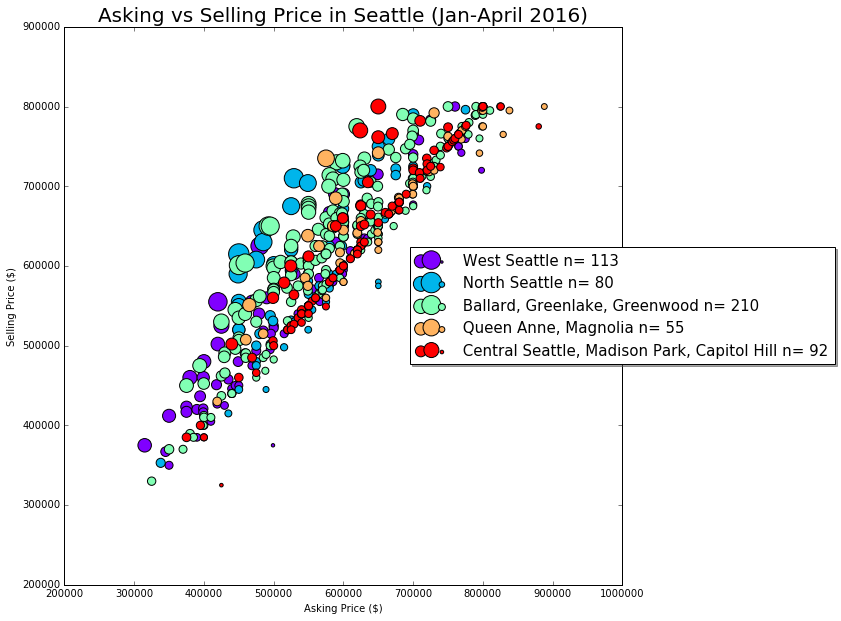

In [135]:
#!/usr/bin/env python3

%matplotlib inline

__author__ = 'ryshackleton'

import sys
import re
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# --- main method ---
def main():
    '''main methods here:
       read some colums from file and plot'''
    # (testing only) convert the .txt input file to .csv
#    do_csv_conversion()
    
    # --- various plots ---
    plot_sale_vs_list_by_neighborhood()

    return 0
# --- end main ---

# --- Plotting ---------------------------------
def plot_sale_vs_list_by_neighborhood():
    # get list of neighborhoods from a file, build hash {integer 3-digit neighborhood code, neighborhood name }
    hoods = get_neighborhood_dict()
        
    # cross reference by neighborhood, so get the list of neighborhoods for parsing
    hoodcode = column_to_list(get_input_filename(),1)
    
    # -- sale vs list price by neighborhood
    # get list and sale prices as lists
    listPrice = column_to_list(get_input_filename(),4)
    salePrice = column_to_list(get_input_filename(),5)
    saleToListRatio = column_to_list(get_input_filename(),7)
    listsByHood = {}
    if len(listPrice) == len(salePrice):
        for (hcode,listp,salep,saleList) in zip(hoodcode, listPrice, salePrice, saleToListRatio):
            if not hcode in listsByHood:
                listsByHood[hcode] = VarLists()
            listsByHood[hcode].append_to_lists(saleList,listp,salep)
            
    # assemble cross plot
    nColors = len(listsByHood.keys())
    x = np.arange(nColors)
    ys = [i+x+(i*x)**2 for i in range(nColors)]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(ys))))
    plt.rcParams["figure.figsize"] = [10.0, 10.0]
    for hcode in listsByHood.keys():
        size = [(float(sl)*2)**6 for sl in listsByHood[hcode]._x]
        plt.scatter(listsByHood[hcode]._y,listsByHood[hcode]._z,s=size,c=next(colors),marker='o',label=hoods[hcode]+' n= {}'.format(len(listsByHood[hcode]._z)))
    legend = plt.legend(loc='center', bbox_to_anchor=(1,0.5),prop={'size':15}, shadow=True)
    plt.title("Asking vs Selling Price in Seattle (Jan-April 2016)",fontsize=20)
    plt.xlabel('Asking Price ($)')
    plt.ylabel('Selling Price ($)')
    plt.show()
    
def plot_list_sale_ratio_histograms(maxListPrice):    
    """Plots a histogram of sale_to_list_ratio for all neighborhoods and filters the homes by maximum listing price"""
    
    # cross reference by neighborhood, so get the list of neighborhoods for parsing
    hoodcode = column_to_list(get_input_filename(),1)
    
    # get list of neighborhoods from a file, build hash {integer 3-digit neighborhood code, neighborhood name }
    hoods = get_neighborhood_dict()
    
    # -- histograms of list to sale ratio by neighborhood
    hood_data = []
    plt.xlabel("Sale to List Ratio")
    plt.ylabel("Probability")
    plt.title('Sale/List Ratio: homes < \${}K in Seattle (Jan-April 2016)'.format(int(maxListPrice/1000)),fontsize=20)
    histData = []
    for hcode in hoods.keys():  
        hood_data = column_to_list_by_neighborhood_code(get_input_filename(),7,hcode,maxListPrice)
    
        if len(hood_data) > 2:
            plt.hist([float(d) for d in hood_data],bins=30,normed=1,label=hoods[hcode]+' n= {}'.format(len(hood_data)),alpha=0.75)
    legend = plt.legend(loc='center', bbox_to_anchor=(1,0.5),prop={'size':15}, shadow=True)
    plt.rcParams["figure.figsize"] = [10.0, 10.0]
    plt.show()

def plot_selling_price_histograms():    
    """Plots a histogram of sale_to_list_ratio for all neighborhoods and filters the homes by maximum listing price"""
    
    # cross reference by neighborhood, so get the list of neighborhoods for parsing
    hoodcode = column_to_list(get_input_filename(),1)
    
    # get list of neighborhoods from a file, build hash {integer 3-digit neighborhood code, neighborhood name }
    hoods = get_neighborhood_dict()
    
    # -- histograms of list to sale ratio by neighborhood
    hood_data = []
    plt.xlabel("Sale Price")
    plt.ylabel("Probability")
    plt.title('Sale Price: homes in Seattle (Jan-April 2016)',fontsize=20)
    histData = []
    for hcode in hoods.keys():  
        hood_data = column_to_list_by_neighborhood_code(get_input_filename(),5,hcode,1000000000)
    
        if len(hood_data) > 2:
            plt.hist([float(d) for d in hood_data],bins=30,normed=1,label=hoods[hcode]+' n= {}'.format(len(hood_data)),alpha=0.75)
    legend = plt.legend(loc='center', bbox_to_anchor=(1.35,0.5),prop={'size':15}, shadow=True)
    plt.rcParams["figure.figsize"] = [10.0, 10.0]
    plt.show()

# --- end Plotting -----------------------------


# -- File IO ------------------------------------------
def get_input_filename():
    '''Set input filename here'''
    return "MLS_2016_4_past3months.txt"

def get_output_filename():
    '''Set output filename here'''
    return "test.csv"

def get_neighborhood_dict():
    '''parses a text file with a list of 3 digit code -> neighborhood names and returns a dictionary of those codes'''
    hoods = {}
    with open("NWMLS_codes.txt", mode='rt', encoding='utf-8') as f:
        for line in f: 
            toks = line.strip().split('\t')
#            if(len(toks) == 2) and isIntable(toks[0]):
#                hoods[int(toks[0])] = toks[1]
            if(len(toks) == 2):
                hoods[toks[0]] = toks[1]
    return hoods

def isIntable(val):
    try:
        int(val)
        return True
    except ValueError:
        return False
    
def get_regex():
    ''' Ridiculously complicated regex to handle the file format below, which gets spit out of the NWMLS (real estate directory).
    A breakdown of capture groups can be found here: https://regex101.com/r/wR8bR9/3
    ---------------- file format example ----------------------
    CMA View
    MLS Area Address CDOM ListingPrice SellingPrice Bds SellingPrice/LisBtitnhgsPrice SF Stat Date BuildingCondition
    913441 710 2531 NE 105th Place 11 450000 615000 3 1.36667 1.5 1,480 04/18/2016
    898598 710 10726 Alton Ave NE 6 529000 710000 3 1.34216 2.5 2,340 04/04/2016 Good
    888455 705 5816 9th Ave NW 7 450000 601000 4 1.33556 1.5 1,840 03/11/2016
    ---------------- file format example ----------------------
    '''
    return re.compile(r"(\d+)\s+(\d+)\s(\d+\s.+)=?\s(\d+)\s(\d{5,6})\s(\d{5,6})\s(\d)\s(\d+?\.?\d*)\s(\d+?\.?\d*)\s(\d+?\,?\d*)\s(\d{2})\/(\d{2})\/(\d{4})\s?(.*)")

def column_to_list_by_neighborhood_code(filename,col_num,neighborhood_code,maxListPrice):
    '''Takes a filename to the absurd MLS format and returns the specified column (0..n-1) as a list,
        delineated by the neighborhood code, which is in column 1 (0-n).
        delineated by the max asking price, which is in column 4 (0-n).
        This method will not work if col_num < 2. '''
    parser = get_regex()
    col = []
    listPrice = []
    with open(filename, mode='rt', encoding='utf-8') as f:
        for line in f:
            matches = parser.match(line)
            if matches:
                ct = 0
                ncode = None
                for word in matches.groups():
                    if ct == 1:
                        n_code = word
                    if ct == col_num and n_code == neighborhood_code:
                        col.append(word)
                    if ct == 4:
                        listPrice.append(word)
                    ct += 1
                    
    # filter by list price
    filterCol = []
    for (listP,cval) in zip(listPrice,col):
        if (int(listP) <= maxListPrice):
            filterCol.append(cval)
    return filterCol

def column_to_list(filename,col_num):
    '''Takes a filename to the absurd MLS format and returns the specified column (0..n-1) as a list'''
    parser = get_regex()
    col = []
    with open(filename, mode='rt', encoding='utf-8') as f:
        for line in f:
            matches = parser.match(line)
            if matches:
                ct = 0
                for word in matches.groups():
                    if ct == col_num :
                        col.append(word)
                    ct += 1
    return col
    
def do_csv_conversion():
    # for testing, conversion from MLS -> .csv format
    convert_to_csv(get_input_filename(),get_output_filename())

def convert_to_csv(filename,outputfilename):
    ''' reads from a file in the local directory with the ridiculous NWMLS (real estate) format:
    and parses the file using a regular expression to split columns to correctly preserve the address format, etc
    Currently just writes to outputfile as comma separated file
    '''
    parser = get_regex()
    with open(outputfilename, mode='w', encoding='utf-8') as of:
        with open(filename, mode='rt', encoding='utf-8') as f:
            for line in f:
                matches = parser.match(line)
                commasep = ""
                if matches:
                    for word in matches.groups():
                        commasep += word + ","
                    of.write(commasep + "\n")
                else:
                    for word in line.strip().split():
                        commasep += word + ","
                    of.write(commasep + "\n")
# -- File IO ------------------------------------------


# --- Data Structures --------------------------
# ----VarLists ---------------------------------
class VarLists:
    """Models a list of 3 variables, stored as lists of the same length """
    def __init__(self):
        """
        Initializes the 3 lists, arbitrarily called x,y, and z 
        :return: None
        """
        self._x = [] 
        self._y = []
        self._z = []
    
    def append_to_lists(self, xv, yv, zv):
        """Append 1 value to each of the three lists"""
        self._x.append(xv)
        self._y.append(yv)
        self._z.append(zv)

    # This establishes the format of the output string 
    def __str__(self):
        return 'VarLists(%s, %s, %s)' % (len(self._x), len(self._y), len(self._z))
# -- Data Structures ---------------------------------

if __name__ == '__main__':
    main()
          

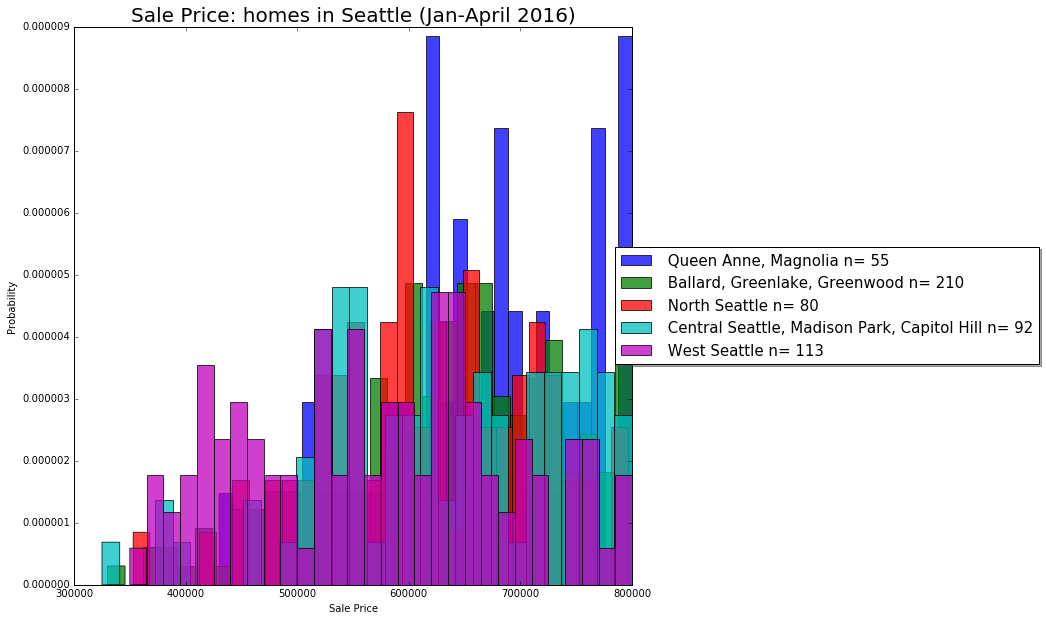

In [136]:
plot_selling_price_histograms()

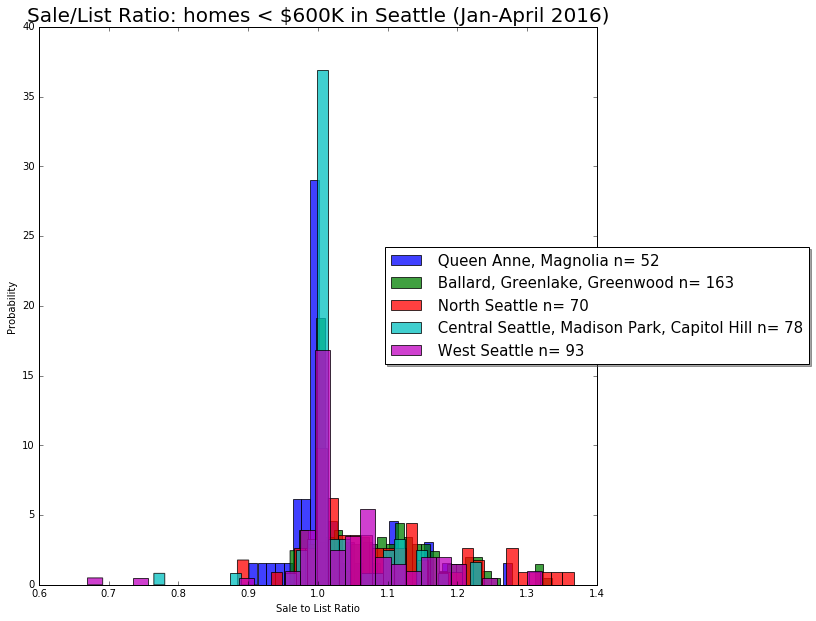

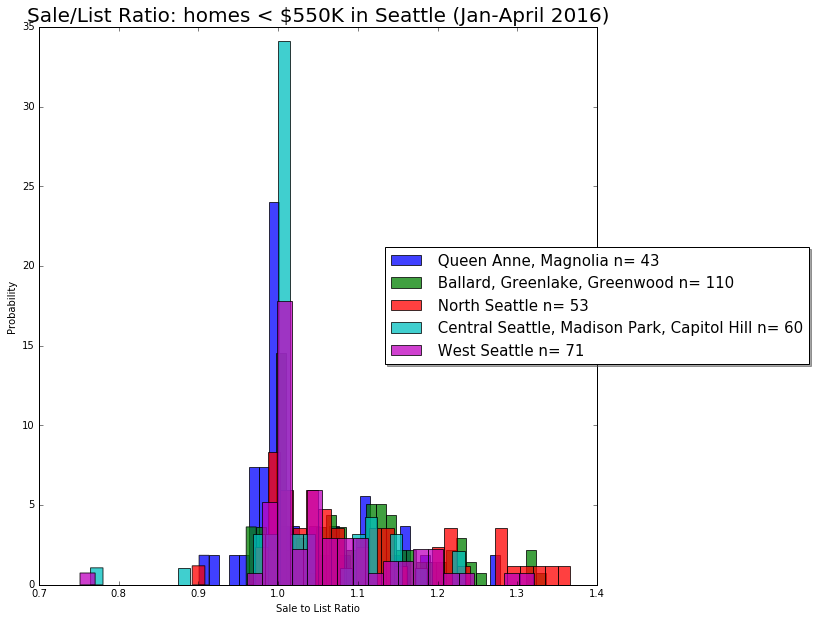

In [137]:

maxListPrice = 600000
plot_list_sale_ratio_histograms(maxListPrice)

maxListPrice = 550000
plot_list_sale_ratio_histograms(maxListPrice)
    
    


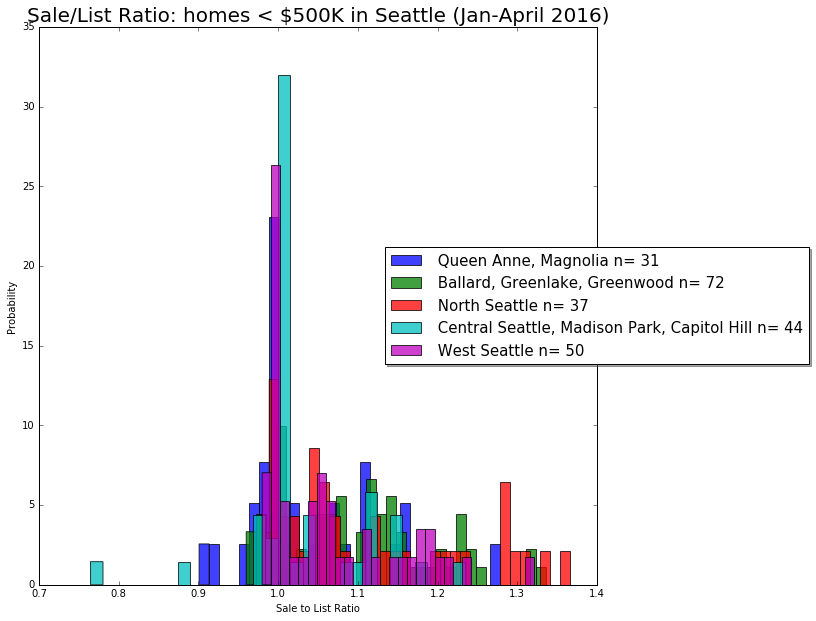

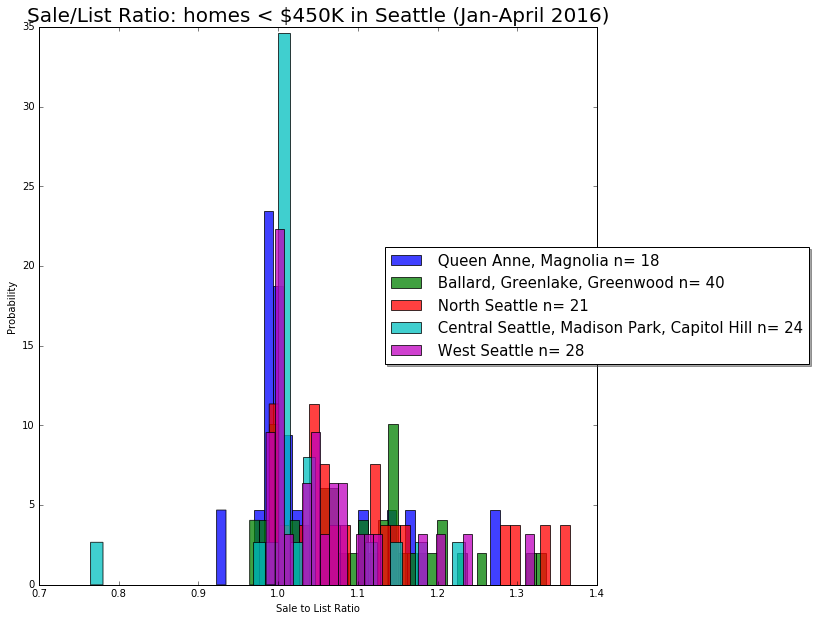

In [138]:

maxListPrice = 500000
plot_list_sale_ratio_histograms(maxListPrice)

maxListPrice = 450000
plot_list_sale_ratio_histograms(maxListPrice)